In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def energy(S, H_p=0):
    """Compute the total energy (divided by J) for a given configuration of the 2D Ising model."""
    
    S_down = np.concatenate([S[1:, :], S[0, :][np.newaxis, :]])
    S_right = np.concatenate([S[:, 1:], S[:, 0][:, np.newaxis]], axis=1)
    
    return -(np.sum(S * S_down) + np.sum(S * S_right)) - H_p * np.sum(S)

In [3]:
def flip(s):
    """Flip a spin."""
    if s == 1:
        return -1
    elif s == -1:
        return 1

In [4]:
def energy_chg(S, i, j, H_p=0):
    """Compute the change of energy (divided by J) due to a spin flip at (i, j)."""
    
    N = S.shape[0]
    newspin = flip(S[i, j])
    
    chg = 0
    if i == 0:
        chg += (- newspin * S[-1, j]) - (- S[i, j] * S[-1, j])
    else:
        chg += (- newspin * S[i-1, j]) - (- S[i, j] * S[i-1, j])
    if i == N-1:
        chg += (- newspin * S[0, j]) - (- S[i, j] * S[0, j])
    else:
        chg += (- newspin * S[i+1, j]) - (- S[i, j] * S[i+1, j])
    if j == 0:
        chg += (- newspin * S[i, -1]) - (- S[i, j] * S[i, -1])
    else:
        chg += (- newspin * S[i, j-1]) - (- S[i, j] * S[i, j-1])
    if j == N-1:
        chg += (- newspin * S[i, 0]) - (- S[i, j] * S[i, 0])
    else:
        chg += (- newspin * S[i, j+1]) - (- S[i, j] * S[i, j+1])
    
    chg += (- H_p * newspin) - (- H_p * S[i, j])
    
    return chg

In [5]:
def Solve2DIsing(S, T_p, steps, H_p=0):
    """
    Compute the energy (divided by J), magnetization, and configuration of the 2D Ising model 
    at a given temperature (times the Bolzmann constant divided by J).
    """
    E_p = energy(S, H_p)
    M = np.sum(S)
    E_p_set = []
    M_set = []
    E_p_set.append(E_p)
    M_set.append(M)
    
    N = S.shape[0]
    
    rng = np.random.default_rng(12345)
    
    for k in range(steps):
        i = rng.integers(N)
        j = rng.integers(N)
        
        dE_p = energy_chg(S, i, j, H_p)
        
        if T_p == 0:
            if dE_p <= 0:
                E_p += dE_p
                M += (flip(S[i, j]) - S[i, j])
                S[i, j] = flip(S[i, j])
        else:
            if rng.random() < np.exp(- dE_p / T_p):
                E_p += dE_p
                M += (flip(S[i, j]) - S[i, j])
                S[i, j] = flip(S[i, j])
                
        E_p_set.append(E_p)
        M_set.append(M)
    
    E_p_set = np.array(E_p_set)
    M_set = np.array(M_set)
    
    # for testing
#     fig, ax = plt.subplots()
#     ax.plot(E_p_set)
#     ax.set_xlabel('steps')
#     ax.set_ylabel(r'$E^{\prime} = \frac{E}{J}$')
#     ax.set_title(f'N{N}_T_p{T_p}_H_p{H_p}')
#     plt.show()
    
#     fig, ax = plt.subplots()
#     ax.plot(M_set / S.size)
#     ax.set_xlabel('steps')
#     ax.set_ylabel(r'Normalized $M$')
#     ax.set_title(f'N{N}_T_p{T_p}_H_p{H_p}')
#     plt.show()

    E_p_avg = np.average(E_p_set[int(steps/2):])
    M_avg = np.average(M_set[int(steps/2):])
    
    return E_p_avg, M_avg, S

In [6]:
def randspin(N):
    """Generate a random configuration of the 2D Ising model."""
    rng = np.random.default_rng(12345)
    A = rng.integers(2, size=(N, N))
    return 2 * A - 1

In [7]:
# number of spins on each row and column of the 2D array
Ns = np.array([50])

# temperature times the Bolzmann constant divided by J, T_p = k * T / J
T_ps = np.arange(0, 5.05, 0.05)[::-1]

# number of steps taken in the Markov chain
steps = 500000

# an additional term to the energy divided by J due to an external magnetic field, H_p = H / J
H_ps = np.array([0.])


In [8]:
for N in Ns:
    for H_p in H_ps:
        S = randspin(N)
        E_ps = []
        Ms = []
        for T_p in T_ps:
            if 2.1 <= T_p <= 2.5:
                E_p, M, S_new = Solve2DIsing(S, T_p, steps * 100, H_p)
            else:
                E_p, M, S_new = Solve2DIsing(S, T_p, steps * 20, H_p)
            # E_p, M, S_new = Solve2DIsing(S, T_p, steps, H_p)
            E_ps.append(E_p)
            Ms.append(M)
            S = S_new

        E_ps = np.array(E_ps)
        Ms = np.array(Ms)
        M_norms = Ms / S.size
        np.save(f'Data/cool_E_ps_N{N}_H_p{H_p}.npy', E_ps)
        np.save(f'Data/cool_Ms_N{N}_H_p{H_p}.npy', Ms)
        np.save(f'Data/cool_M_norms_N{N}_H_p{H_p}.npy', M_norms)

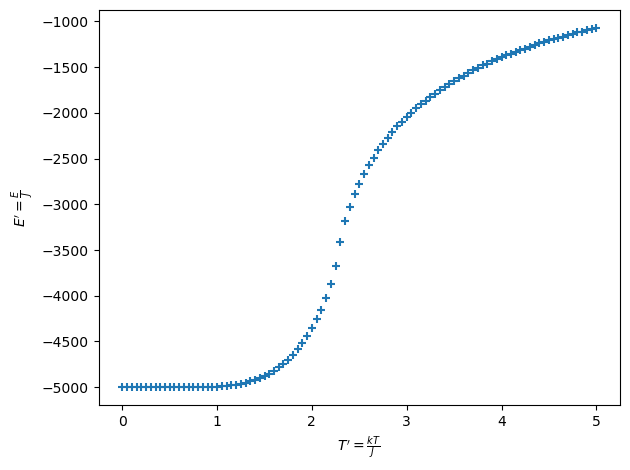

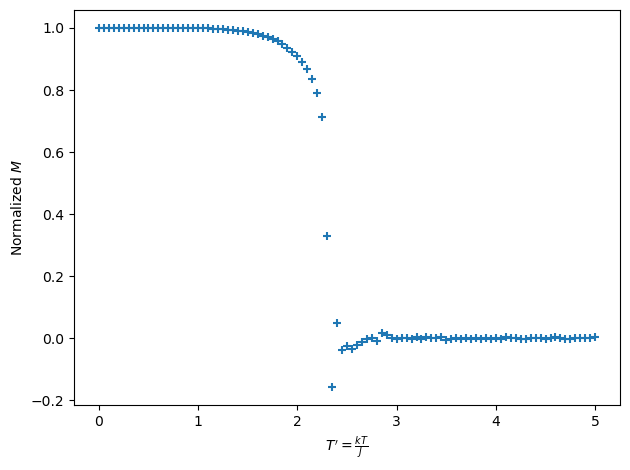

In [9]:
fig, ax = plt.subplots()
ax.scatter(T_ps, E_ps, marker='+')
ax.set_xlabel(r'$T^{\prime} = \frac{kT}{J}$')
ax.set_ylabel(r'$E^{\prime} = \frac{E}{J}$')
fig.tight_layout()
plt.savefig(f'Figs/cool_E_ps_N{N}_H_p{H_p}.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
ax.scatter(T_ps, M_norms, marker='+')
ax.set_xlabel(r'$T^{\prime} = \frac{kT}{J}$')
ax.set_ylabel(r'Normalized $M$')
fig.tight_layout()
plt.savefig(f'Figs/cool_M_norms_N{N}_H_p{H_p}.png', bbox_inches='tight')
plt.show()